In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Setting
sns.despine(left=True, bottom=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format','{:.4f}'.format)
sns.set()

%matplotlib inline

In [2]:
jams_bogor_feat_eng = pd.read_parquet('..\\dataset\\jams_bogor_feat_eng.parquet')
jams_bogor = jams_bogor_feat_eng.copy()

In [17]:
jams_bogor.sample(3)

,street,median_length,median_delay,median_speed_kmh,total_records,median_level,weekday,month,day,is_weekday,hour,is_working_hour,is_morning,is_lunch,is_late_afternoon,is_late_night,time_span,median_length__mean,median_length__median,median_length__std,median_delay__mean,median_delay__median,median_delay__std,median_speed_kmh__mean,median_speed_kmh__median,median_speed_kmh__std,total_records__mean,total_records__median,total_records__std,median_level__mean,median_level__median,median_level__std,percentile_5_median_length,percentile_25_median_length,percentile_75_median_length,percentile_95_median_length,percentile_5_median_delay,percentile_25_median_delay,percentile_75_median_delay,percentile_95_median_delay,percentile_5_median_speed_kmh,percentile_25_median_speed_kmh,percentile_75_median_speed_kmh,percentile_95_median_speed_kmh,percentile_5_total_records,percentile_25_total_records,percentile_75_total_records,percentile_95_total_records,percentile_5_median_level,percentile_25_median_level,percentile_75_median_level,percentile_95_median_level,overall_occurance,occurance_time_span_6,occurance_time_span_1,occurance_time_span_2,occurance_time_span_3,occurance_time_span_4,occurance_time_span_5,occurance_weekday_2,occurance_weekday_3,occurance_weekday_4,occurance_weekday_5,occurance_weekday_6,occurance_weekday_0,occurance_weekday_1
45062,pulo empang,326.0000,261.0000,3.8300,4,4.0000,1,8,2,1,7,0,1,0,0,0,2,523.5838,566.0000,84.1991,155.3735,114.0000,101.9128,9.4279,9.5400,3.4493,14.6462,11.0000,13.4475,2.5936,3.0000,0.7753,326.0000,482.0000,590.0000,590.0000,61.0000,75.0000,211.0000,370.2000,4.1590,6.4900,12.5200,14.6060,1.0000,5.0000,20.0000,42.4000,2.0000,2.0000,3.0000,4.0000,913,3.0000,NaN,272.0000,418.0000,163.0000,57.0000,105.0000,116.0000,125.0000,180.0000,178.0000,99.0000,110.0000
65334,kapten yusuf,841.0000,76.0000,16.8000,5,1.0000,5,8,13,0,19,0,0,0,0,0,5,670.6703,558.0000,279.5539,157.6393,99.0000,156.3013,11.1666,11.3800,4.4277,19.9887,14.0000,19.0368,2.2130,2.0000,1.0031,334.0000,461.0000,799.0000,1166.0000,62.0000,75.0000,168.2500,453.8500,3.6430,7.7500,14.8400,17.7585,2.0000,6.0000,28.0000,58.0000,1.0000,1.0000,3.0000,4.0000,2484,28.0000,1.0000,483.0000,926.0000,545.0000,501.0000,324.0000,340.0000,361.0000,451.0000,400.0000,303.0000,305.0000
33798,tumenggung wiradireja,1040.0000,85.5000,14.5300,8,1.0000,1,7,26,1,17,0,0,0,1,0,4,612.6206,580.0000,282.2102,113.6250,89.0000,76.1304,10.0390,10.6850,3.3477,9.3259,7.5000,8.7849,1.9854,2.0000,0.8389,176.0000,404.0000,754.7500,1084.0000,62.0000,72.0000,123.1250,253.3000,3.8718,7.7013,12.7850,14.7695,1.0000,3.0000,12.0000,27.0000,1.0000,1.0000,3.0000,3.0000,1028,4.0000,1.0000,207.0000,335.0000,262.0000,219.0000,154.0000,122.0000,136.0000,219.0000,141.0000,139.0000,117.0000


In [20]:
jams_bogor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102322 entries, 0 to 102321
Data columns (total 66 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   street                          102322 non-null  object 
 1   median_length                   102322 non-null  float32
 2   median_delay                    102322 non-null  float32
 3   median_speed_kmh                102322 non-null  float32
 4   total_records                   102322 non-null  int32  
 5   median_level                    102322 non-null  float32
 6   weekday                         102322 non-null  int32  
 7   month                           102322 non-null  int32  
 8   day                             102322 non-null  int32  
 9   is_weekday                      102322 non-null  int32  
 10  hour                            102322 non-null  int32  
 11  is_working_hour                 102322 non-null  int32  
 12  is_morning      

In [3]:
jams_bogor = jams_bogor.fillna(0)

## Outliers

In [4]:
def outlier_imputer(dataframe):
    for col in dataframe.columns:
        q1 = np.percentile(dataframe[col], 25)
        q3 = np.percentile(dataframe[col], 75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr

        # obtain outliers' indexes
        query_top = f'{col} > (@q3 + @outlier_step)'
        query_below = f'{col} < (@q1 - @outlier_step)'
        outlier_series_top = dataframe.query(query_top)
        outlier_series_below = dataframe.query(query_below)

        # impute oulier values
        dataframe.loc[outlier_series_top.index, col] = q3 + outlier_step
        dataframe.loc[outlier_series_below.index, col] = q1 - outlier_step
    
    return dataframe

In [5]:
jams_bogor = outlier_imputer(jams_bogor.select_dtypes(include='number'))

# Clustering 1

## Feature Selection & Clustering 1

In [6]:
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(jams_bogor)

In [8]:
pca_out = PCA(n_components=0.7).fit_transform(scaled_data)
pca_cols = [ f'PCA {i}' for i in range(1, pca_out.shape[1]+1)]
df_pca = pd.DataFrame(pca_out, columns=pca_cols)

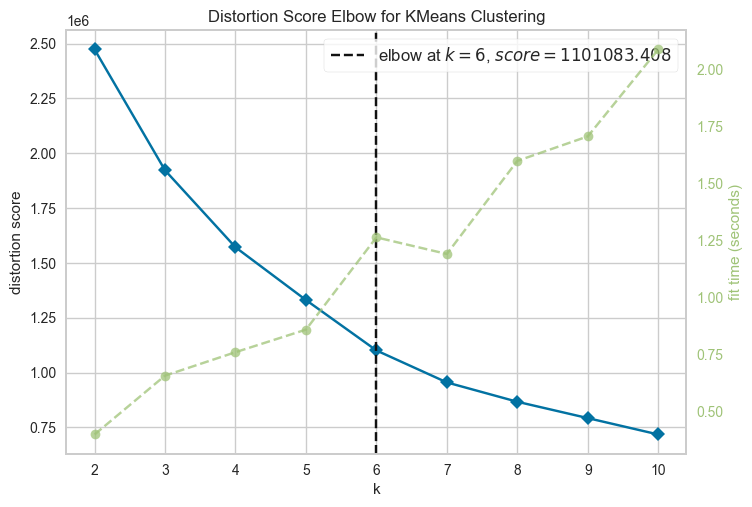

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
Elbow_M = KElbowVisualizer(KMeans(), k=10) # check for 10 clusters
Elbow_M.fit(df_pca)
Elbow_M.show() # from elbow method, 5 clusters are the good numbers of cluster

In [10]:
cluster = (
            KMeans(n_clusters = Elbow_M.elbow_value_)
            .fit_predict(df_pca)    
    )

In [11]:
jams_bogor['cluster'] = cluster

## Check Cluster Characteristics

In [28]:
cluster_corr = jams_bogor.corr()['cluster'].sort_values(ascending=False).reset_index()
cluster_corr = cluster_corr.rename(columns={'index': 'columns', 'cluster': 'correlation'})
cluster_corr = cluster_corr.dropna(axis=0)
cluster_corr['corr_abs'] = np.abs(cluster_corr.correlation)
cluster_corr = cluster_corr.sort_values('corr_abs', ascending=False)

In [29]:
cluster_corr.head(10)

,columns,correlation,corr__abs
0,cluster,1.0000,1.0000
58,median_delay__median,-0.4290,0.4290
57,percentile_25_median_delay,-0.4180,0.4180
56,occurance_time_span_3,-0.3893,0.3893
55,percentile_5_median_delay,-0.3801,0.3801
54,percentile_75_median_delay,-0.3753,0.3753
53,occurance_time_span_4,-0.3544,0.3544
52,median_delay__mean,-0.3412,0.3412
51,occurance_weekday_1,-0.3192,0.3192
50,occurance_weekday_3,-0.3079,0.3079


In [30]:
jams_bogor.cluster.value_counts()

5    27428
0    24748
1    21877
3    16465
2     9876
4     1928
Name: cluster, dtype: int64

In [31]:
sel_cols = [
    'median_length', 'median_delay', 'median_speed_kmh', 'total_records','median_level', 'overall_occurance', 'cluster'
    ]

In [66]:
(
    jams_bogor[sel_cols]
    .groupby('cluster')
    .agg(['median', lambda x: pd.Series.mad(x)])
    .style.background_gradient(cmap='magma')
    )

# median & mad values of each cluster group

In [38]:
jams_bogor.to_parquet('..\\dataset\\jams_bogor_cluster_trial2.parquet')

---
---

# Clustering 2

## Feature Selection & Clustering 2

In [50]:
jams_bogor_2 = jams_bogor.copy()
jams_bogor_2 = jams_bogor_2.drop('cluster', axis=1)

In [51]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(jams_bogor_2)

In [52]:
pca_out = PCA(n_components=0.7).fit_transform(scaled_data)
pca_cols = [ f'PCA {i}' for i in range(1, pca_out.shape[1]+1)]
df_pca = pd.DataFrame(pca_out, columns=pca_cols)

In [53]:
cluster = (
            KMeans(n_clusters = 4) # from previous clustering result, let's check for 3 clusters only
            .fit_predict(df_pca)    
    )

In [54]:
jams_bogor_2['cluster'] = cluster

## Check Cluster Characteristics

In [55]:
cluster_corr = jams_bogor_2.corr()['cluster'].sort_values(ascending=False).reset_index()
cluster_corr = cluster_corr.rename(columns={'index': 'columns', 'cluster': 'correlation'})
cluster_corr = cluster_corr.dropna(axis=0)
cluster_corr['corr_abs'] = np.abs(cluster_corr.correlation)
cluster_corr = cluster_corr.sort_values('corr_abs', ascending=False)

In [56]:
cluster_corr.head(10)

,columns,correlation,corr_abs
0,cluster,1.0000,1.0000
58,occurance_time_span_6,-0.3137,0.3137
57,occurance_time_span_1,-0.2979,0.2979
56,percentile_95_total_records,-0.2864,0.2864
55,total_records__std,-0.2644,0.2644
54,total_records__median,-0.2595,0.2595
53,percentile_75_total_records,-0.2518,0.2518
52,total_records__mean,-0.2340,0.2340
51,percentile_25_total_records,-0.1425,0.1425
50,median_length__median,-0.1238,0.1238


In [57]:
jams_bogor_2.cluster.value_counts()

1    40447
2    26152
3    19258
0    16465
Name: cluster, dtype: int64

In [58]:
sel_cols = [
    'median_length', 'median_delay', 'median_speed_kmh', 'total_records','median_level', 'overall_occurance', 'cluster'
    ]

In [62]:
(
    jams_bogor_2[sel_cols]
    .groupby('cluster')
    .agg(['median'])
    .style.background_gradient(cmap='magma')
    )

,median_length,median_delay,median_speed_kmh,total_records,median_level,overall_occurance
,median,median,median,median,median,median
cluster,,,,,,
0,1115.000000,106.000000,17.750000,25.000000,2.000000,3174.000000
1,528.000000,96.000000,10.290000,8.000000,2.000000,821.000000
2,1162.000000,91.500000,20.365000,10.000000,2.000000,1789.000000
3,581.000000,108.000000,10.280000,14.000000,3.000000,2010.000000


In [63]:
jams_bogor_2.to_parquet('..\\dataset\\jams_bogor_cluster_trial3.parquet')